In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [4]:
import matplotlib.pyplot as plt
import cv2

NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(images, labels, ncols=8):
  figure, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(22, 6))
  for i in range(ncols):
    axs[i].imshow(images[i])
    label = np.squeeze(labels[i])
    axs[i].set_title(NAMES[int(label)])

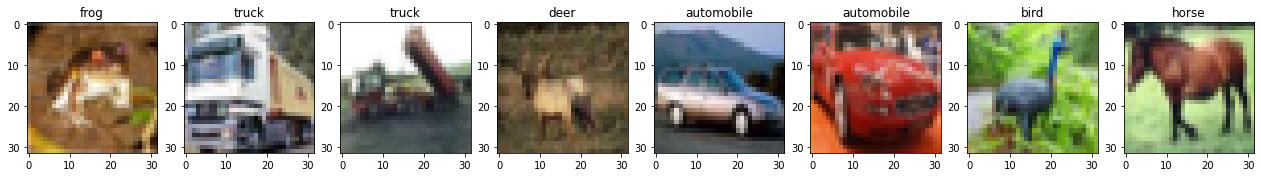

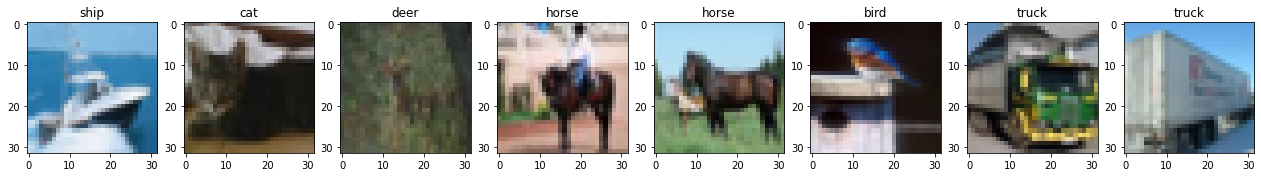

In [5]:
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

In [6]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
  horizontal_flip=True,
  rescale=1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

test_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Flatten 대신 Global AveragePooling 을 적용. 
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
        
    return model

In [9]:
model = create_model(verbose=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

2022-09-21 00:06:56.082366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 00:06:56.202770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 00:06:56.203953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 00:06:56.206361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0     

In [10]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = model.fit(flow_tr_gen, epochs=40, steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), validation_data=flow_val_gen,
    validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), callbacks=[rlr_cb, ely_cb])

Epoch 1/40


2022-09-21 00:06:59.131170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-21 00:07:01.333921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


665/665 [==============================] - 22s 20ms/step - loss: 1.4171 - accuracy: 0.4906 - val_loss: 1.3260 - val_accuracy: 0.5097
Epoch 2/40
665/665 [==============================] - 11s 17ms/step - loss: 1.0175 - accuracy: 0.6422 - val_loss: 0.9047 - val_accuracy: 0.6876
Epoch 3/40
665/665 [==============================] - 12s 17ms/step - loss: 0.8278 - accuracy: 0.7159 - val_loss: 1.5871 - val_accuracy: 0.5379
Epoch 4/40
665/665 [==============================] - 11s 17ms/step - loss: 0.7000 - accuracy: 0.7640 - val_loss: 0.7438 - val_accuracy: 0.7487
Epoch 5/40
665/665 [==============================] - 11s 17ms/step - loss: 0.6196 - accuracy: 0.7924 - val_loss: 0.6666 - val_accuracy: 0.7725
Epoch 6/40
665/665 [==============================] - 12s 17ms/step - loss: 0.5437 - accuracy: 0.8165 - val_loss: 0.5789 - val_accuracy: 0.8025
Epoch 7/40
665/665 [==============================] - 11s 17ms/step - loss: 0.4823 - accuracy: 0.8392 - val_loss: 0.6422 - val_accuracy: 0.7793
Epo

In [11]:
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 7ms/step - loss: 0.4655 - accuracy: 0.8980


[0.4654560089111328, 0.8980000019073486]

In [12]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

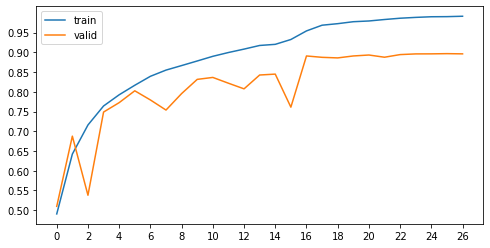

In [13]:
show_history(history)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
  rotation_range=20,
  zoom_range=(0.7, 0.9),
  horizontal_flip=True,
  vertical_flip=True,  
  rescale=1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

test_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(flow_tr_gen, epochs=30, validation_data=flow_val_gen, callbacks=[rlr_cb, ely_cb], verbose=1)

Epoch 1/30
665/665 [==============================] - 25s 36ms/step - loss: 1.7616 - accuracy: 0.3439 - val_loss: 1.8648 - val_accuracy: 0.3391
Epoch 2/30
665/665 [==============================] - 22s 34ms/step - loss: 1.4351 - accuracy: 0.4761 - val_loss: 2.9381 - val_accuracy: 0.2493
Epoch 3/30
665/665 [==============================] - 23s 35ms/step - loss: 1.2733 - accuracy: 0.5508 - val_loss: 1.9558 - val_accuracy: 0.4096
Epoch 4/30
665/665 [==============================] - 23s 34ms/step - loss: 1.1500 - accuracy: 0.5949 - val_loss: 1.1588 - val_accuracy: 0.5881
Epoch 5/30
665/665 [==============================] - 24s 36ms/step - loss: 1.0607 - accuracy: 0.6292 - val_loss: 1.2244 - val_accuracy: 0.5744
Epoch 6/30
665/665 [==============================] - 25s 37ms/step - loss: 1.0035 - accuracy: 0.6509 - val_loss: 1.1945 - val_accuracy: 0.5945
Epoch 7/30
665/665 [==============================] - 25s 38ms/step - loss: 0.9368 - accuracy: 0.6753 - val_loss: 1.1994 - val_accuracy:

In [17]:
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 7ms/step - loss: 0.5889 - accuracy: 0.8084


[0.5888966917991638, 0.8083999752998352]